# Web Scraping and Linear Regression with Car Data

Purpose: web scrape used car data and estimate pricing based on car attributes like age, mileage, color, and model type

In [1]:
# bs4=BeautifulSoup for parsing the HTML text returned from a URL
# requests gets our HTML text

import bs4
import requests
import pandas as pd
from datetime import datetime

# Scraping a single URL

Note: 
* 05/29/20: These links may rot as cars get sold. Go to CarFax.com, apply a few search filters, and click on several cars of interest.
* In this example, we use the Honda Civic for year 2017 or higher

In [2]:
# the soup object contains the full HTML text and car attributes
url = 'https://www.carfax.com/vehicle/2HGFC3A56KH750872'
resp = requests.get(url)
soup = bs4.BeautifulSoup(resp.text)

print(resp.text[:1000], end='\n\n')
print(type(soup))

<!DOCTYPE html>
<html>

<head>
  <title data-react-helmet="true">2HGFC3A56KH750872 | 2019 Honda Civic Si for sale in Joliet, IL </title>
  <link rel='dns-prefetch' href='https://media.carfax.com' />
  <link rel='dns-prefetch' href='https://static.carfax.com' />
  <link rel='preconnect' crossorigin='true' href='https://carfax-img.vast.com' />
  <link rel="manifest" href="/manifest.json" />
  <link rel="apple-touch-icon" href="https://static.carfax.com/uclassets/images/favicon-228.png">
  <link rel="apple-touch-startup-image" href="https://static.carfax.com/uclassets/images/favicon-228.png">
  <meta name="theme-color" content="#3777bc"/>
  <meta http-equiv="X-UA-Compatible" content="IE=edge" />
  <meta charset="UTF-8" />
  <script type='text/javascript' >window.NREUM||(NREUM={});NREUM.info = {"agent":"","beacon":"bam.nr-data.net","errorBeacon":"bam.nr-data.net","licenseKey":"c882024f46","applicationID":"53224171","applicationTime":135.944934,"transactionName":"M1EBYkcEDEpQBk1QDQobJk5FFwd

In [3]:
# use soup selecters to narrow down to HTML containing data 
soup.select('.vehicle-info-details')

[<div class="vehicle-info-details vehicle-info-details-title">Price </div>,
 <div class="vehicle-info-details-price vehicle-info-details">$21,000</div>,
 <div class="vehicle-info-details vehicle-info-details-title">Mileage </div>,
 <div class="vehicle-info-details">16,788 miles </div>,
 <div class="vehicle-info-details vehicle-info-details-title">Location </div>,
 <div class="vehicle-info-details">Joliet, IL </div>,
 <div class="vehicle-info-details vehicle-info-details-title">Exterior Color </div>,
 <div class="vehicle-info-details">Blue</div>,
 <div class="vehicle-info-details vehicle-info-details-title">Interior Color </div>,
 <div class="vehicle-info-details">Black</div>,
 <div class="vehicle-info-details vehicle-info-details-title">Drive Type </div>,
 <div class="vehicle-info-details">FWD</div>,
 <div class="vehicle-info-details vehicle-info-details-title">Transmission </div>,
 <div class="vehicle-info-details">Manual</div>,
 <div class="vehicle-info-details vehicle-info-details-t

In [4]:
# parse data points of interest

# multiple assignment trick
    # the '*_' assigns an arbitrary number of elements that we don't care about to '_'
    # idiom for throw-away variables that we don't use is the '_' single underscore character 

# price, mileage, etc are 'tag' elements
_, price, _, mileage, _, loc, _, color_ext, *_ = soup.select('.vehicle-info-details')
price, mileage, loc, color_ext

(<div class="vehicle-info-details-price vehicle-info-details">$21,000</div>,
 <div class="vehicle-info-details">16,788 miles </div>,
 <div class="vehicle-info-details">Joliet, IL </div>,
 <div class="vehicle-info-details">Blue</div>)

In [5]:
# get text from from tag elements via tag.getText() and store in dictionary format

columns=['price', 'mileage', 'loc', 'color_ext']
data_vals = [xtag.getText() for xtag in [price, mileage, loc, color_ext]]
data = zip(columns, data_vals)
data = dict(data)
data

{'price': '$21,000',
 'mileage': '16,788 miles ',
 'loc': 'Joliet, IL ',
 'color_ext': 'Blue'}

In [6]:
# convert dictionary to dataframe

df = pd.DataFrame.from_dict(data, orient='index').T
df['url'] = url
df

,price,mileage,loc,color_ext,url
0,"$21,000","16,788 miles","Joliet, IL",Blue,https://www.carfax.com/vehicle/2HGFC3A56KH750872


# Make this a function, loop through a list of URLs, and consolidate

In [7]:
def url_to_df(url):
    '''Parse data from carfax url

    Example
    -------
    >>> url = 'https://www.carfax.com/vehicle/SHHFK7H48JU208178'
    >>> df = parse_url(url)
    '''
    resp = requests.get(url)
    try:
        resp.raise_for_status()
    except:
        print(f'HTTP Error for URL: {url}')
        return None
    soup = bs4.BeautifulSoup(resp.text)
    _, price, _, mileage, _, loc, _, color_ext, *_ = soup.select('.vehicle-info-details')
    columns=['price', 'mileage', 'loc', 'color_ext']
    data_vals = [x.getText() for x in [price, mileage, loc, color_ext]]
    data = zip(columns, data_vals)
    data = dict(data)
    df = pd.DataFrame.from_dict(data, orient='index').T
    df['mileage'] = df['mileage'].str.replace(' miles', '')
    df['url'] = url
    df['label'] = soup.select('.vehicle-title')[0].getText()
    df['year'] = df['label'].str.slice(0,4)
    df = df[['label', 'year', 'mileage', 'price', 'color_ext', 'loc', 'url']]
    return df


In [8]:
urls = ['https://www.carfax.com/vehicle/2HGFC2F6XKH516438',
 'https://www.carfax.com/vehicle/19XFB2F52FE095230',
 'https://www.carfax.com/vehicle/SHHFK7H57JU237048',
 'https://www.carfax.com/vehicle/SHHFK7H54JU209689',
 'https://www.carfax.com/vehicle/19XFB2F71FE024814',
 'https://www.carfax.com/vehicle/2HGFC3A56KH750872',
 'https://www.carfax.com/vehicle/19XFC1F31HE017014',
 'https://www.carfax.com/vehicle/2HGFC3B70HH361556',
 'https://www.carfax.com/vehicle/2HGFC4B60KH304679',
 'https://www.carfax.com/vehicle/SHHFK7H42HU211538',
 'https://www.carfax.com/vehicle/SHHFK7H56HU232918',
 'https://www.carfax.com/vehicle/19XFA1F50BE030688',
 'https://www.carfax.com/vehicle/2HGFC3B39JH352003',
 'https://www.carfax.com/vehicle/19XFC2F57JE025910',
 'https://www.carfax.com/vehicle/2HGFC4B50GH301957',
 'https://www.carfax.com/vehicle/2HGFC3B72JH351813',
 'https://www.carfax.com/vehicle/19XFB2F50FE059830',
 'https://www.carfax.com/vehicle/19XFB2F50FE059830',
 'https://www.carfax.com/vehicle/19XFC2F59JE007764',
 'https://www.carfax.com/vehicle/19XFB2F56FE114488',
 'https://www.carfax.com/vehicle/19XFC2F50HE075008',
 'https://www.carfax.com/vehicle/2HGFC3B32GH351929',
 'https://www.carfax.com/vehicle/2HGFC3B34HH355773',
 'https://www.carfax.com/vehicle/2HGFC2F71HH525403',
 'https://www.carfax.com/vehicle/19XFC2F5XHE034790']

In [ ]:
# initialize empty dataframe and concatenate new sub dataframes with itself
df_all = pd.DataFrame()
for url in urls:
    print(url)
    df_sub = url_to_df(url)
    df_all = pd.concat([df_all, df_sub])

df_all = df_all.reset_index(drop=True)

# convert price string to integer 
df_all['price'] = df_all['price'].str.replace('$','').str.replace(',','').astype(int)

https://www.carfax.com/vehicle/2HGFC2F6XKH516438
https://www.carfax.com/vehicle/19XFB2F52FE095230
https://www.carfax.com/vehicle/SHHFK7H57JU237048
HTTP Error for URL: https://www.carfax.com/vehicle/SHHFK7H57JU237048
https://www.carfax.com/vehicle/SHHFK7H54JU209689
https://www.carfax.com/vehicle/19XFB2F71FE024814
https://www.carfax.com/vehicle/2HGFC3A56KH750872
https://www.carfax.com/vehicle/19XFC1F31HE017014
https://www.carfax.com/vehicle/2HGFC3B70HH361556


In [ ]:
df_all

# Predictive model using ordinary least squares regression (OLS)

### Primer
* Relationship between dependent variable (value we want to predict)
* Constant/intercept
* Slope coefficient
* Random error term

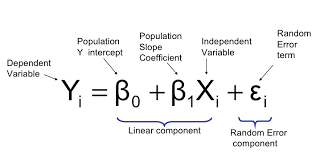

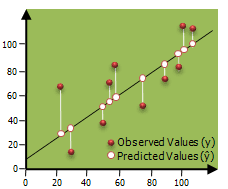

![image.png](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR-tWrEwqgBkxDc2KOkS-RvsLd6b4XTUdQ9LsdWrhS65UCGY8I7&usqp=CAU)

### Prepare model inputs
* note that we omit 1 of the model dummy variables
* use n-1 dummy variables where n=number of unique categories
* reference
    * https://stats.stackexchange.com/questions/115049/why-do-we-need-to-dummy-code-categorical-variables

In [ ]:
# y is independent variable to predict that depends on X's
# convention is capital X for predictor variables

y = df_all['price']
X = pd.DataFrame(index=df_all.index)

# format X variables 
X['age'] = datetime.today().year - df_all['year'].astype(int)
X['mileage'] = df_all['mileage'].str.replace(',','').astype(int)
# X['dummy_lx'] = df_all['label'].str.lower().str.contains('lx').astype(int)
X['dummy_ex'] = df_all['label'].str.lower().str.contains('ex').astype(int)
X['dummy_si'] = df_all['label'].str.lower().str.contains('si').astype(int)
X['dummy_sport'] = df_all['label'].str.lower().str.contains('sport').astype(int)

In [ ]:
X.head(10)

In [ ]:
# merge to view prepared variables with original dataframe
merged = df_all.merge(X, left_index=True, right_index=True)
merged.head(10).drop(columns='url')

In [ ]:
X.describe()

### Fit the model and inspect result parameters

In [ ]:
# for more documentation on Ordinary Least Squares with statsmodels, see:
    # https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html
    # you can also check out scikit-learn which has a similar API pattern
    # "model" object that takes array-like objects

import statsmodels.api as sm

# Our model needs an intercept so we add a column of 1s
X = sm.add_constant(X)

# ex: for binary outcome instead, could use 'model = sm.logit(y, W)'
model = sm.OLS(y, X)
result = model.fit()
result.summary()

**Interpretation**
* Subtract $1303 for every year as age penalty
* Mileage is insignficant. Low coefficient and high p-value. This feels wrong. We have too little data and perhaps we need to represent this variable differently.
* LX model starts at constant of \\$18,020. \\$3166-\\$3638 dollars if it's Sport, Ex, or Si model.
* R-squared is high. 99%+ of variance can be explained by these variables. 
    * It's also possible that our model is over-fit.

In [ ]:
print(result.summary())

In [ ]:
# other items of interest
print('Parameters: ', result.params, sep='\n', end='\n\n')
print('Standard errors: ', result.bse, sep='\n', end='\n\n')
print('Predicted values: ', result.predict(), sep='\n', end='\n\n')

### Examine actual vs predicted price

In [ ]:
# if the predicted price is higher than the actual, this might suggest a bargain
# barring no other variables (ex: might want to add variables like # owners and prior accidents)
df_all['predicted_price'] = result.predict()
df_all['diff'] = df_all['predicted_price'] - df_all['price']
df_all[['label', 'year', 'mileage', 'color_ext', 'loc', 'url', 'price', 'predicted_price', 'diff']].round(2)\
      .drop(columns='url')\
      .sort_values(by='diff', ascending=False)

### Test on new data

In [ ]:
# say I observe a new data point/car that's 2 years old, 30,000 miles, and model LX
# what should the predicted price be?

age = 2
mileage = 30_000
dummy_ex = 0
dummy_si = 0
dummy_sport = 0

new_data = pd.Series([1, age, mileage, dummy_ex, dummy_si, dummy_sport], index=result.params.index)
predicted = (result.params*new_data).sum()

print('predicted price: ', predicted, sep='\n', end='\n\n')
print('params: ', result.params, sep='\n', end='\n\n')
print('new_data: ', new_data, sep='\n', end='\n\n')

# Exercise
* Make a similar regression model but introduce the 'color' variable and see if 

# Topics not covered
* model validation and test vs. training data sets
* feature engineering / identifying variables and inspecting for redundant correlations
* other regression and/or machine learning models

Typically, before we select our features, we might explore relationships visually through plots or correlation heat maps.

In [ ]:
import seaborn as sns
sns.set()

# negative relationship between mileage and price
df_all.merge(X, left_index=True, right_index=True).plot(x='mileage_y', y='price', kind='scatter')